# Data exploration

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon, Patch
%matplotlib inline

import cv2

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [4]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_pansharpened, generated_upsampled_swir, generate_label_image, spot_cleaning
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st

In [5]:
#!ls {DATA_16_BANDS} | head

From internet sources : http://www.satpalda.com/product/worldview-3/
        
Panchromatic 	

    Panchromatic: 450 – 800 nm


Multispectral (8 Bands) 	

    Coastal : 400 – 450 nm
    Blue : 450 – 510 nm
    Green : 510 – 580 nm
    Yellow : 585 – 625 nm
    Red : 630 – 690 nm
    Red Edge : 705 – 745 nm
    Near-IR1 : 770 – 895 nm
    Near-IR2 : 860 – 1040 nm


SWIR Bands (8 Bands) 	

    SWIR-1 : 1195 – 1225 nm
    SWIR-2 : 1550 – 1590 nm
    SWIR-3 : 1640 – 1680 nm
    SWIR-4 : 1710 – 1750 nm
    SWIR-5 : 2145 – 2185 nm
    SWIR-6 : 2185 – 2225 nm
    SWIR-7 : 2235 – 2285 nm
    SWIR-8 : 2295 – 2365 nm
    
    
    
From Kaggle :

Imagery details

Sensor : WorldView 3

Wavebands :

    - Panchromatic: 450-800 nm
    - 8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm
    - 8 SWIR: 1195 nm - 2365 nm


Sensor Resolution (GSD) at Nadir :

    Panchromatic: 0.31m 
    Multispectral: 1.24 m
    SWIR: Delivered at 7.5m

Dynamic Range
    
    - Panchromatic and multispectral : 11-bits per pixel
    - SWIR : 14-bits per pixel

In [6]:
from image_utils import print_image_info

In [12]:
print_image_info('6140_0_0', 'pan'), print_image_info('6110_0_0', 'pan')

('Image size:', 3348, 3396, 1)
('Metadata:', ['TIFFTAG_COPYRIGHT=(C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmont CO USA 80503', 'TIFFTAG_DATETIME=2016:03:30 19:52:16', 'TIFFTAG_IMAGEDESCRIPTION={\n  bandList = \n  [\n    1;\n  ]\n}', 'TIFFTAG_MAXSAMPLEVALUE=2047', 'TIFFTAG_MINSAMPLEVALUE=425'])
('MetadataDomainList:', ['', 'IMAGE_STRUCTURE'])
('Description:', '../input/sixteen_band/6140_0_0_P.tif')
('ProjectionRef:', '')
('GeoTransform:', (0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
('Image size:', 3348, 3396, 1)
('Metadata:', ['TIFFTAG_COPYRIGHT=(C) COPYRIGHT 2016 DigitalGlobe, Inc., Longmont CO USA 80503', 'TIFFTAG_DATETIME=2016:03:30 20:37:42', 'TIFFTAG_IMAGEDESCRIPTION={\n  bandList = \n  [\n    1;\n  ]\n}', 'TIFFTAG_MAXSAMPLEVALUE=2047', 'TIFFTAG_MINSAMPLEVALUE=160'])
('MetadataDomainList:', ['', 'IMAGE_STRUCTURE'])
('Description:', '../input/sixteen_band/6110_0_0_P.tif')
('ProjectionRef:', '')
('GeoTransform:', (0.0, 1.0, 0.0, 0.0, 0.0, 1.0))


(None, None)

```
TIFF info:  6      2        3       7     4      8        5         9
1 - Pan

Kaggle :  (red, red edge, coastal, blue, green, yellow, near-IR1, near-IR2)

TIFF + Web : Red, Coastal, Blue, Red Edge, Green, Near-IR1, Yellow, Near-IR2
               1     2      3       4        5        6        7        8

Web : Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
         1       2    3       4      5      6          7        8
         0       1    2       3      4      5          6        7   

Web :    
1 Pan 
2 1 Coastal 
3 2 Blue
4 3  Green
5 4 Yellow
6 5 Red
7 6 Red Edge
8 7 Near-IR1
9 8 Near-IR2
```

RGB <-> 5,3,2 for (17b)

```
Near-Infrared (0.7-1) to 5   
Mid-Infrared   5 to (25-40)
```


```
NDVI (Red, NIR)  -> ndvi_57 | [ndvi_67] | ndvi_58 | ndvi_68
GEMI (Red, NIR)  -> gemi_57 | [gemi_67] | gemi_58 | gemi_68

NDWI (NIR, MIR)  -> ndwi_717 ~~~
NDWI2 (Green, NIR) -> [ndwi2_37] | ndwi2_38
NDTI (Red, Green) -> ndti_53 | ndti_63 ~~~
MNDWI (Green, MIR) -> mndwi_317
```

```
Red = 5, 6 (17b)
NIR = 7, 8 (17b)
Green = 3 (17b)
MIR = 17 (17b)
```



## Visualize a training image

In [8]:
TRAIN_IMAGE_IDS

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [9]:
from ipywidgets import interact, IntSlider, FloatSlider   

def interactive_display_image_id(image_id, labels=None, plus_shapes=False):

    generate_pansharpened(image_id, 'ms')
    generated_upsampled_swir(image_id, 'swir')

    try:
        label_img = generate_label_image(image_id, labels=labels)
        is_test_image=False
    except:
        is_test_image=True

    img_pan = get_image_data(image_id, 'pan')
    #img_pan = spot_cleaning(img_pan, 7, threshold=0.15)


    try:
        img_3b = get_image_data(image_id, '3b')
        #img_3b = spot_cleaning(img_3b, 7, threshold=0.15)
    except:
        img_3b = None

    img_ms = get_image_data(image_id, 'ms_pan')
    #img_ms = spot_cleaning(img_ms, 7, threshold=0.15)
        
    img_swir = get_image_data(image_id, 'swir_upsampled')
    #img_swir = spot_cleaning(img_swir, 3, threshold=0.15)   


    fig_size = (14, 6)
    def interactive_visu(roi_x, roi_w, roi_y, roi_h, alpha):

        roi = [roi_x, roi_y, roi_x+roi_w, roi_y+roi_h]

        plt.figure(figsize=(12, 12))
        ax = plt.gca()
        display_img_1b(img_pan)
        if not is_test_image:
            display_labels(label_img, alpha=alpha)
        ax.add_patch(Rectangle((roi_x, roi_y), roi_w, roi_h, alpha=1, facecolor='none', edgecolor='red'))
        plt.suptitle("Pansharpened image")

        plt.figure(figsize=fig_size)
        plt.subplot(121)
        display_img_1b(img_pan, roi)
        plt.suptitle("Pansharpened image ROI")
        plt.subplot(122)
        display_img_1b(img_pan, roi)
        if not is_test_image:
            display_labels(label_img, roi, alpha=alpha)
        plt.suptitle("Pansharpened image ROI + SHP")



        if img_3b is not None:
            plt.figure(figsize=fig_size)
            ax_array = display_img_3b(img_3b, roi)
            plt.suptitle("3 bands image ROI")
            if plus_shapes and not is_test_image:
                display_labels(label_img, roi, ax_array, alpha=alpha)


        plt.figure(figsize=fig_size)
        ax_array = display_img_8b(img_ms, roi)
        plt.suptitle("8 bands image ROI")
        if plus_shapes and not is_test_image:
            display_labels(label_img, roi, ax_array, alpha=alpha)



        plt.figure(figsize=fig_size)
        ax_array = display_img_8b(img_swir, roi)
        #ax_array = display_img_8b(img_swir, [r/4/6 for r in roi])
        plt.suptitle("8 bands SWIR image ROI")
        if plus_shapes and not is_test_image:
            display_labels(label_img, roi, ax_array, alpha=alpha)


    _ = interact(interactive_visu,           
             roi_x=IntSlider(value=500, min=0, max=3500, continuous_update=False), 
             roi_w=IntSlider(value=500, min=150, max=750, continuous_update=False), 
             roi_y=IntSlider(value=1, min=0, max=3500, continuous_update=False), 
             roi_h=IntSlider(value=500, min=150, max=750, continuous_update=False),
             alpha=FloatSlider(value=0.5, min=0, max=1.0, step=0.1, continuous_update=False))
    

In [56]:
TRAIN_WKT[TRAIN_WKT['ImageId'] == '6110_4_0']

ImageId  ClassType                                    MultipolygonWKT
80  6110_4_0          1  MULTIPOLYGON (((0.007546 -0.005158, 0.007584 -...
81  6110_4_0          2  MULTIPOLYGON (((0.002344 -0.008668, 0.002349 -...
82  6110_4_0          3  MULTIPOLYGON (((0 -0.00549, 0 -0.005339, 0.000...
83  6110_4_0          4  MULTIPOLYGON (((0 -0.008017, 5.5e-05 -0.008007...
84  6110_4_0          5  MULTIPOLYGON (((0.00666 -0.009039999999999999,...
85  6110_4_0          6  MULTIPOLYGON (((0.009169 -0.007217, 0.009169 -...
86  6110_4_0          7                                 MULTIPOLYGON EMPTY
87  6110_4_0          8  MULTIPOLYGON (((0.000287 -0.006791, 0.000251 -...
88  6110_4_0          9  MULTIPOLYGON (((0.000367 -0.004805, 0.000318 -...
89  6110_4_0         10  MULTIPOLYGON (((0.001628 -0.003359, 0.001653 -...

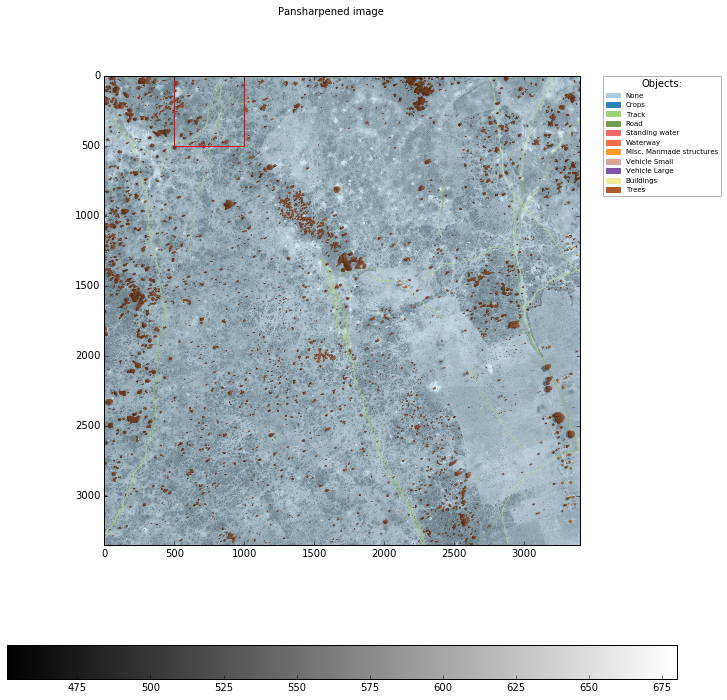

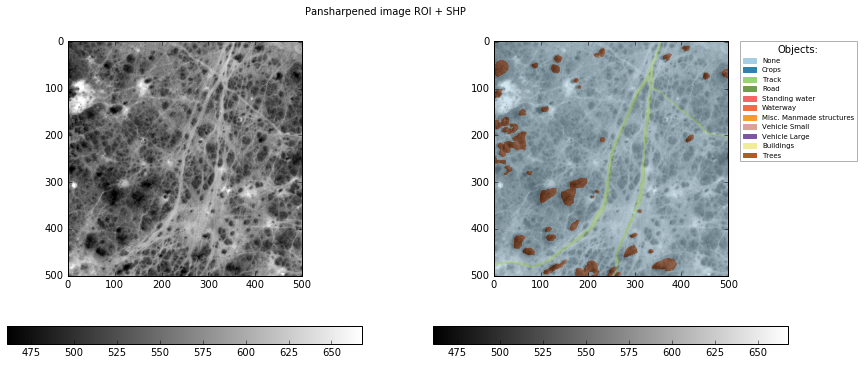

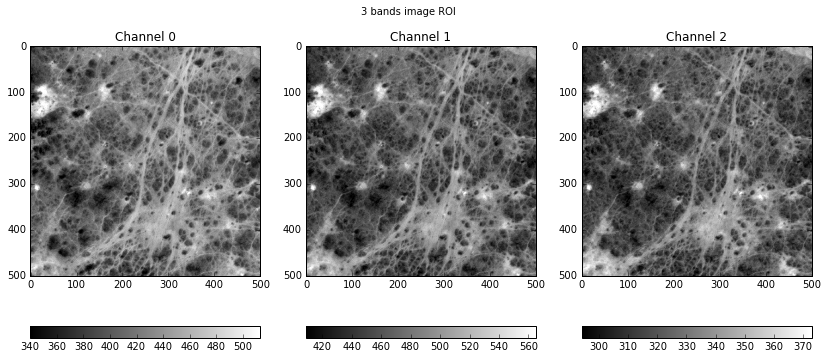

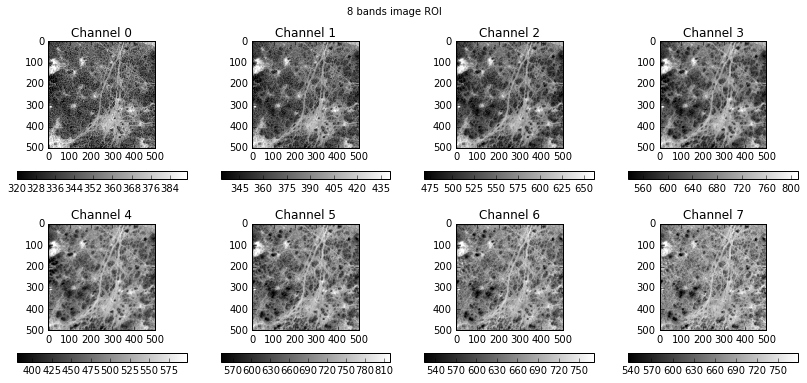

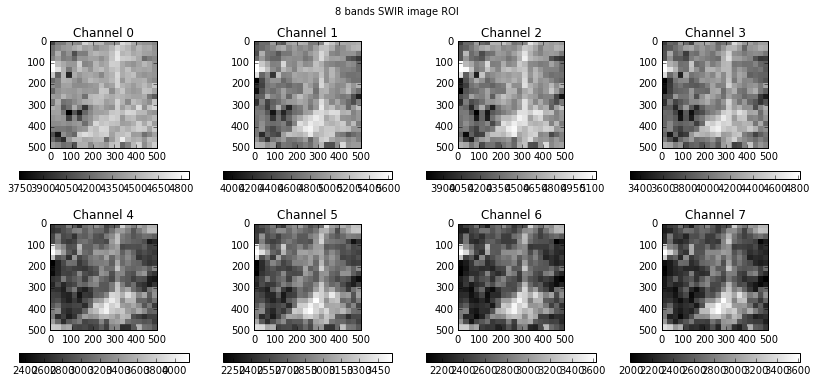

In [58]:
# image_id = "6120_2_2"
# image_id = "6010_4_2"
#image_id = "6110_3_1"

# image_id = "6110_1_2"
# image_id = "6120_2_2"
# image_id = "6110_4_0"
image_id = "6010_1_2"

# labels = np.array([0,1,2,3,4,6,7,8,9,10])
interactive_display_image_id(image_id)

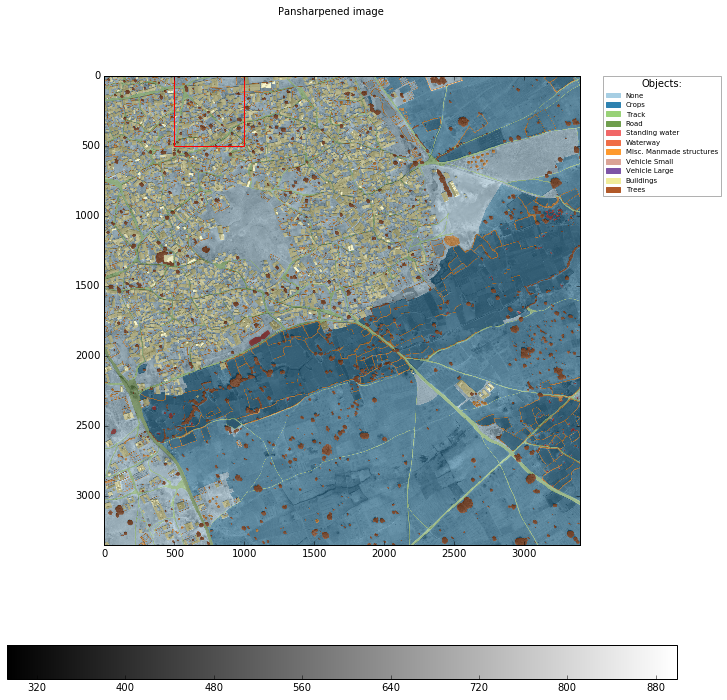

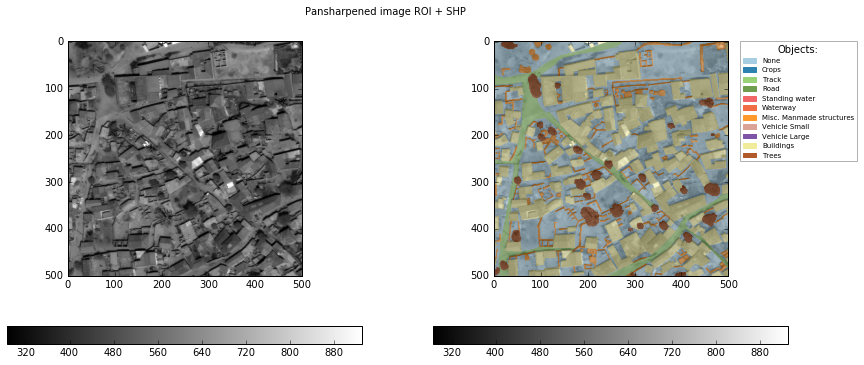

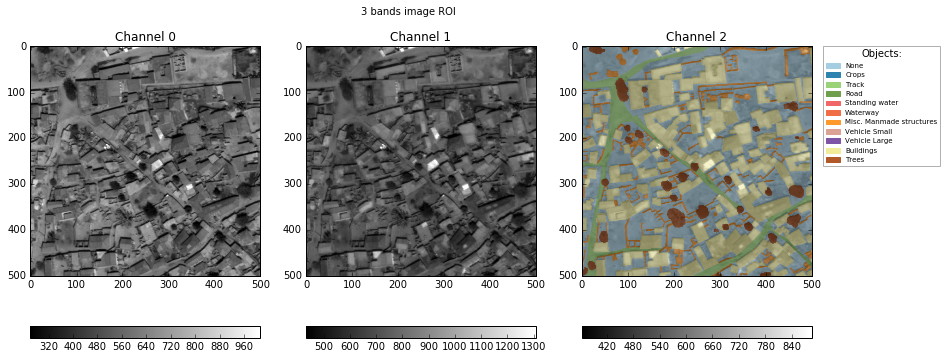

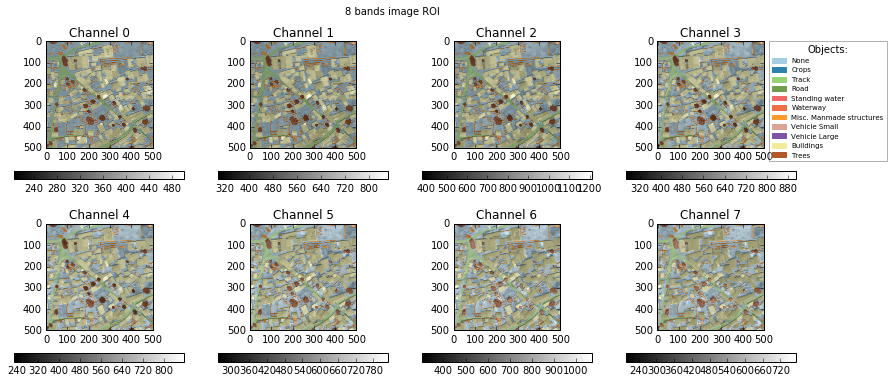

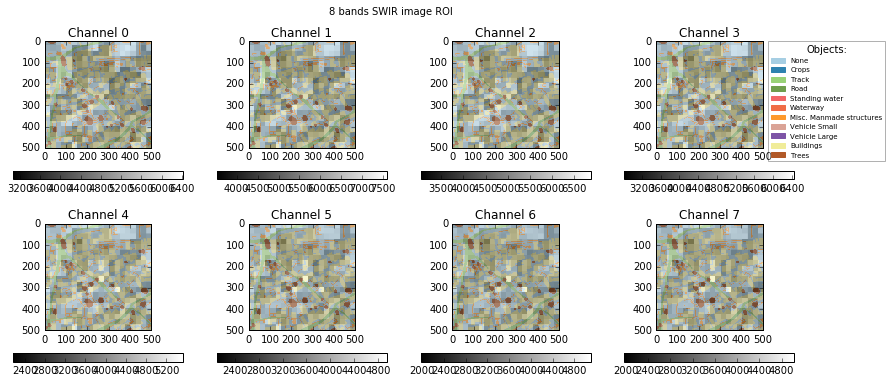

In [12]:
image_id = "6110_1_2"

interactive_display_image_id(image_id)

## Visualize tiles of XYZW image, e.g. '6010'

In [21]:
tile_size = (256, 256)
n, m = 5, 5

In [204]:
def create_complete_image(ids, tile_size=(256, 256), n=5, m=5):
    complete_image = np.zeros((5*tile_size[0], 5*tile_size[1]), dtype=np.uint16)
    for i in range(n):
        ys = i*tile_size[1]
        ye = ys + tile_size[1]
        for j in range(m):
            xs = j*tile_size[0]
            xe = xs + tile_size[0]
            image_id = ids + "_%i_%i" % (i, j)
            img = get_image_data(image_id, 'pan')
            img = cv2.resize(img, dsize=tile_size)
            complete_image[ys:ye, xs:xe] = img
    return complete_image

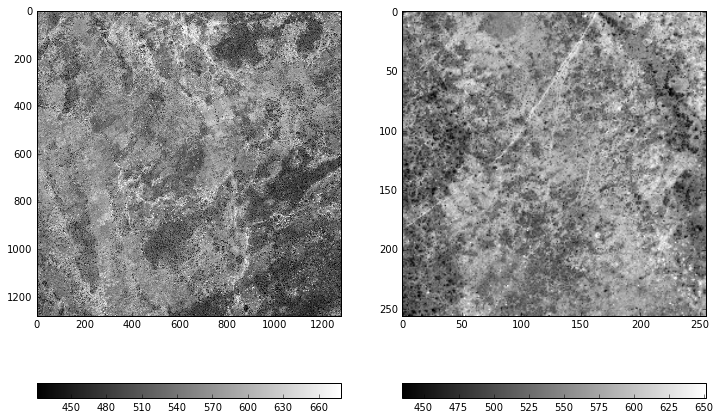

In [205]:
ids = "6010"
complete_image = create_complete_image(ids)

plt.figure(figsize=(12,8))
plt.subplot(121)
display_img_1b(complete_image)
plt.subplot(122)
display_img_1b(complete_image, roi=[128,128,128+256,128+256])

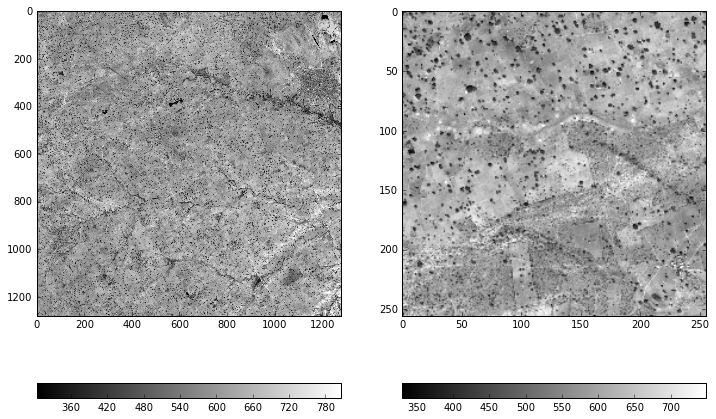

In [206]:
ids = "6020"

complete_image = create_complete_image(ids)

plt.figure(figsize=(12,8))
plt.subplot(121)
display_img_1b(complete_image)
plt.subplot(122)
display_img_1b(complete_image, roi=[128,128,128+256,128+256])

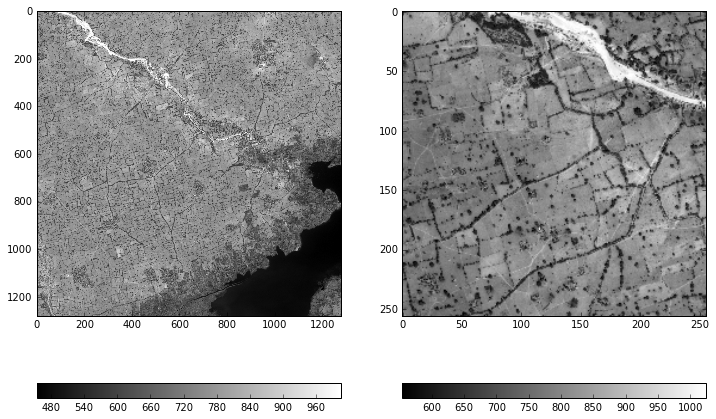

In [207]:
ids = "6030"

complete_image = create_complete_image(ids)

plt.figure(figsize=(12,8))
plt.subplot(121)
display_img_1b(complete_image)
plt.subplot(122)
display_img_1b(complete_image, roi=[128,128,128+256,128+256])

Store all panchromatic images in one with resolution of MS

In [10]:
import os
from data_utils import GENERATED_DATA
from visu_utils import scale_percentile

In [13]:
import gdal

def generate_all_tiles_image():
    filename = os.path.join(GENERATED_DATA, 'all_tiles_pan_image.tif')
    assert not os.path.exists(filename), "Image is already created. Remove it if you need to regenerate it"

    all_ids = sorted(np.unique([iid[:-4] for iid in ALL_IMAGE_IDS]).tolist())
    n, m = 5, 5
    tile_size = 850
    n_tiles = len(all_ids)
    nx = 5
    ny = int(np.ceil(n_tiles / float(nx)))
    width = tile_size * n * nx
    height = tile_size * m * ny

    print n_tiles, nx, ny, width, height

    # Initialize output file:
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(filename, width, height, 1, gdal.GDT_Byte)
    assert dataset is not None, "Failed to create a file"

    band = dataset.GetRasterBand(1)

    for index, ids in enumerate(all_ids):
        print "Process id: ", ids, index, '/', n_tiles
        tile = np.zeros((5*tile_size, 5*tile_size), dtype=np.uint16)
        for i in range(n):
            ys = i*tile_size
            ye = ys + tile_size
            for j in range(m):
                xs = j*tile_size
                xe = xs + tile_size
                image_id = ids + "_%i_%i" % (i, j)
                img = get_image_data(image_id, 'pan')
                img = cv2.resize(img, dsize=(tile_size, tile_size), interpolation=cv2.INTER_CUBIC)            
                tile[ys:ye, xs:xe] = img   
        
        tile_8u = scale_percentile(tile, 0.1, 99.9)
        tile_8u = cv2.putText(tile_8u, ids, (5,tile_8u.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 10.0, (255, 255, 255), thickness=15)
        xi = index % nx                    
        yi = int(np.floor(index * 1.0 / nx))
        xoffset = xi * tile_size * n
        yoffset = yi * tile_size * m
        band.WriteArray(tile_8u, xoff=xoffset, yoff=yoffset)

    dataset = None
    
generate_all_tiles_image()

18 5 4 21250 17000
Process id:  6010 0 / 18
Process id:  6020 1 / 18
Process id:  6030 2 / 18
Process id:  6040 3 / 18
Process id:  6050 4 / 18
Process id:  6060 5 / 18
Process id:  6070 6 / 18
Process id:  6080 7 / 18
Process id:  6090 8 / 18
Process id:  6100 9 / 18
Process id:  6110 10 / 18
Process id:  6120 11 / 18
Process id:  6130 12 / 18
Process id:  6140 13 / 18
Process id:  6150 14 / 18
Process id:  6160 15 / 18
Process id:  6170 16 / 18
Process id:  6180 17 / 18


Same for train data

In [12]:
import gdal

def generate_train_tiles_image():
    filename = os.path.join(GENERATED_DATA, 'train_tiles_pan_image.tif')
    assert not os.path.exists(filename), "Image is already created. Remove it if you need to regenerate it"

    tile_size = (1024, 1024)
    n, m = 5, 5
    complete_image = np.zeros((5*tile_size[0], 5*tile_size[1]), dtype=np.uint8)
    train_ids = sorted(TRAIN_IMAGE_IDS)
    counter = 0
    for i in range(n):
        ys = i*tile_size[1]
        ye = ys + tile_size[1]
        for j in range(m):
            xs = j*tile_size[0]
            xe = xs + tile_size[0]
            image_id = train_ids[counter]; counter+=1
            img = get_image_data(image_id, 'pan')
            img = cv2.resize(img, dsize=tile_size)    
            img_8u = scale_percentile(img, 0.1, 99.9)
            img_8u = cv2.putText(img_8u, image_id, (5,img_8u.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255, 127), thickness=2)            
            complete_image[ys:ye, xs:xe] = img_8u[:,:,0] if len(img_8u.shape) > 2 else img_8u
    
    
    # Initialize output file:
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(filename, complete_image.shape[1], complete_image.shape[0], 1, gdal.GDT_Byte)
    assert dataset is not None, "Failed to create a file"

    band = dataset.GetRasterBand(1)
    band.WriteArray(complete_image, xoff=0, yoff=0)

    dataset = None
    
generate_train_tiles_image()

##  Visualize all 25 training images

In [28]:
TRAIN_IMAGE_IDS

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [18]:
train_ids = sorted(TRAIN_IMAGE_IDS)
print train_ids

['6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2', '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2', '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4', '6170_4_1']


In [22]:
tile_size = (512, 512)
n, m = 5, 5

In [23]:
# '6110_1_2','6140_1_2',

In [26]:
from image_utils import normalize

complete_image = np.zeros((5*tile_size[0], 5*tile_size[1]), dtype=np.float32)
train_ids = sorted(TRAIN_IMAGE_IDS)
counter = 0
for i in range(n):
    ys = i*tile_size[1]
    ye = ys + tile_size[1]
    for j in range(m):
        xs = j*tile_size[0]
        xe = xs + tile_size[0]
        image_id = train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'pan')
        img = cv2.resize(img, dsize=tile_size)
        img = normalize(img)
        complete_image[ys:ye, xs:xe] = img[:,:,0] if len(img.shape) > 2 else img

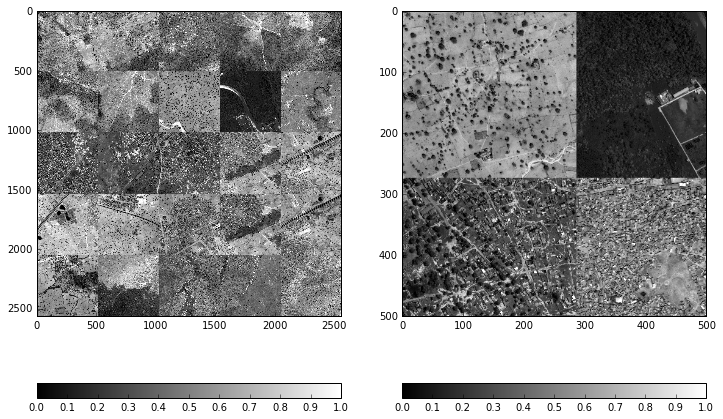

In [27]:
plt.figure(figsize=(12,8))
plt.subplot(121)
display_img_1b(complete_image)
plt.subplot(122)
display_img_1b(complete_image, roi=[1250,750,1250+500,750+500])
# display_img_1b(complete_image, roi=[250,250,250+500,250+500])

In [33]:
print train_ids[7], train_ids[8]

6060_2_3 6070_2_3


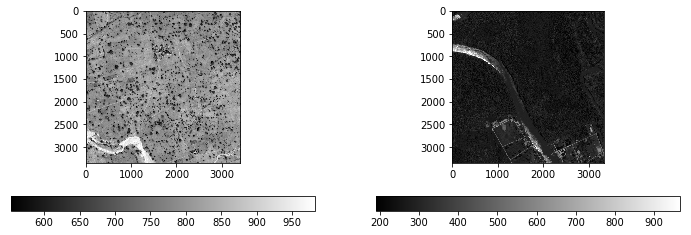

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(121)
display_img_1b(get_image_data("6060_2_3", 'pan'))
plt.subplot(122)
display_img_1b(get_image_data("6070_2_3", 'pan'))

## Class distrubutions on training dataset


In [5]:
from data_utils import get_unit_polygons, get_resized_polygons

In [6]:
training_distrib_class_freq = list([0]*len(LABELS))
training_distrib_class_surface = list([0]*len(LABELS))
training_distrib_class_n_images = list([0]*len(LABELS))

In [7]:
h, w, _ = get_image_data(TRAIN_IMAGE_IDS[0], 'pan', return_shape_only=True)
for image_id in TRAIN_IMAGE_IDS:
    polygons = get_resized_polygons(image_id, 'pan')
    for class_type in polygons:
        poly = polygons[class_type]
        training_distrib_class_surface[class_type] += poly.area * 1.0/ (h*w)
        training_distrib_class_freq[class_type] += len(poly)
        if len(poly) > 0:
            training_distrib_class_n_images[class_type] += 1.0 / len(TRAIN_IMAGE_IDS)

In [8]:
# for image_id in TRAIN_IMAGE_IDS:
#     img_label = get_image_data(image_id, 'label')
#     for i in range(len(LABELS)):
#         training_distrib_class_surface[i] += cv2.countNonZero(img_label[:,:,i]) * 1.0/ (h*w)

In [9]:
for i, n, s, a, c in zip(range(1,11), training_distrib_class_freq[1:], training_distrib_class_surface[1:], training_distrib_class_n_images[1:], LABELS[1:]):
    print "Class :", i, ' - ', c
    print " -- nb polygons:", n
    print " -- surface ratio:", s
    print " -- appearing freq:", a
    print " -- surface per item * appearence freq :", s * a

Class : 1  -  Buildings
 -- nb polygons: 12011
 -- surface ratio: 0.826325299107
 -- appearing freq: 0.48
 -- surface per item * appearence freq : 0.396636143572
Class : 2  -  Misc. Manmade structures
 -- nb polygons: 12315
 -- surface ratio: 0.176383054134
 -- appearing freq: 0.68
 -- surface per item * appearence freq : 0.119940476811
Class : 3  -  Road
 -- nb polygons: 14
 -- surface ratio: 0.202226497263
 -- appearing freq: 0.44
 -- surface per item * appearence freq : 0.0889796587959
Class : 4  -  Track
 -- nb polygons: 239
 -- surface ratio: 0.750718954178
 -- appearing freq: 0.92
 -- surface per item * appearence freq : 0.690661437844
Class : 5  -  Trees
 -- nb polygons: 48347
 -- surface ratio: 2.54269410218
 -- appearing freq: 1.0
 -- surface per item * appearence freq : 2.54269410218
Class : 6  -  Crops
 -- nb polygons: 422
 -- surface ratio: 6.89110605224
 -- appearing freq: 0.56
 -- surface per item * appearence freq : 3.85901938926
Class : 7  -  Waterway
 -- nb polygons: 2

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


Training class groups : (number of pixels / number of objects) x appearence frequency

1. `Buildings` and `Trees` and `Standing water` : [1, 5, 8]
2. `Misc. Manmade structures` and `Vehicle Large` and `Vehicle Small` : [2, 9, 10]
3. `Track` and `Road` and `Crops`: [4, 3, 6]
4. `Waterway` : [7]

## Visualize preprocessed data

In [11]:
TRAIN_IMAGE_IDS

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

In [45]:
img_input.shape

(3348L, 3391L, 17L)

In [5]:
# image_id = '6140_1_2' # 6 8 

# plt.figure(figsize=(12,12))
# display_labels(get_image_data(image_id,'label_1d'))

In [ ]:
# take some pictures from test 
waterway_test = ['6080_4_3','6080_4_0',
                 '6080_1_3', '6080_1_1',
                 '6150_3_4', '6050_2_1']

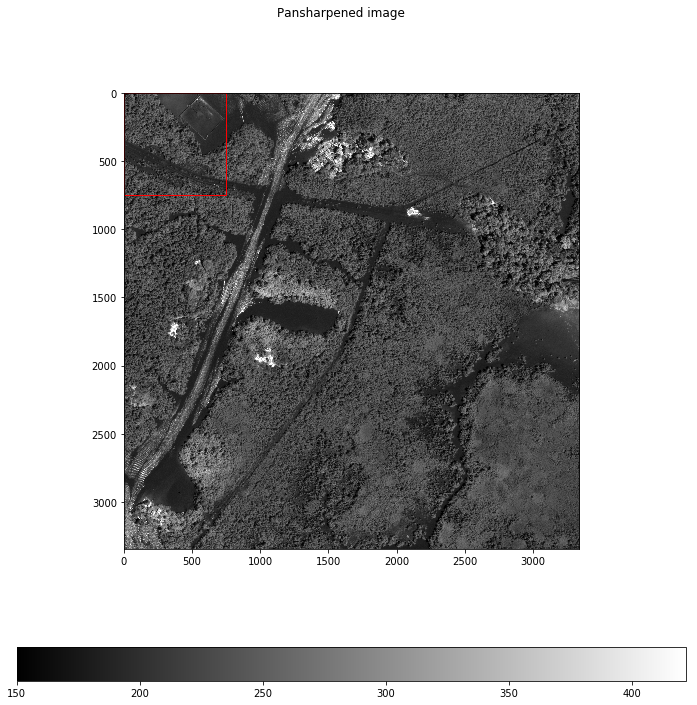

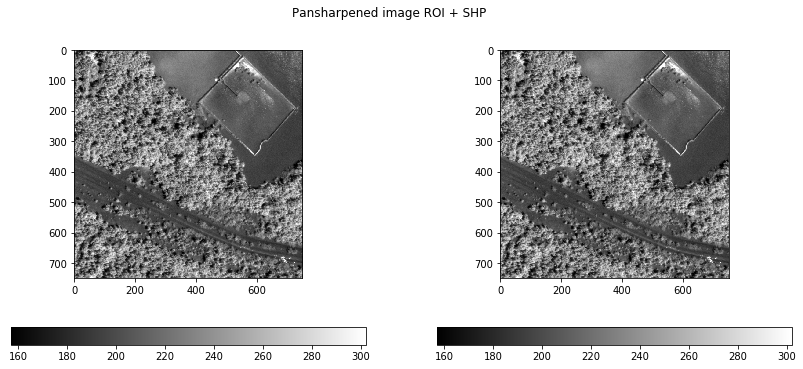

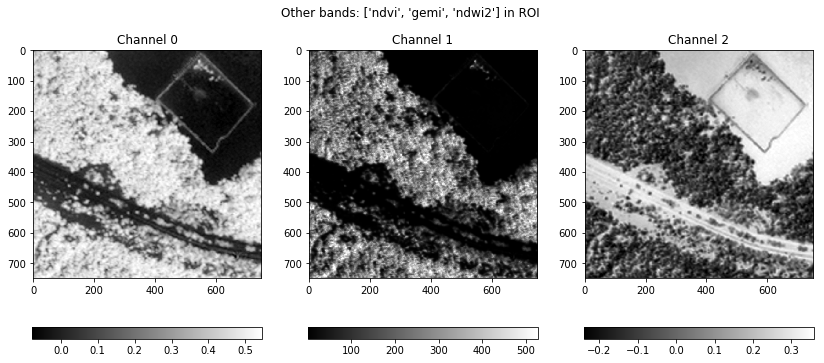

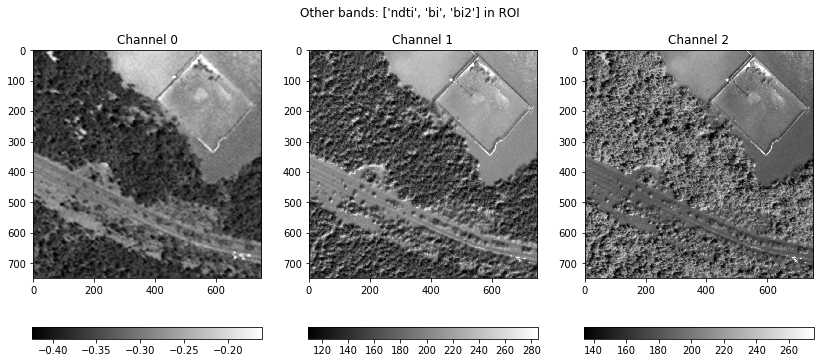

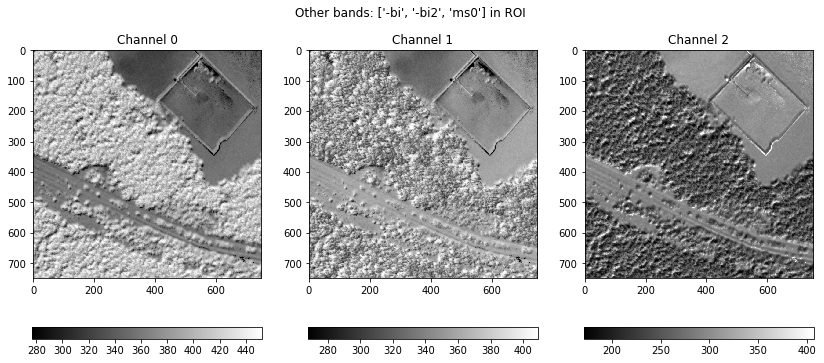

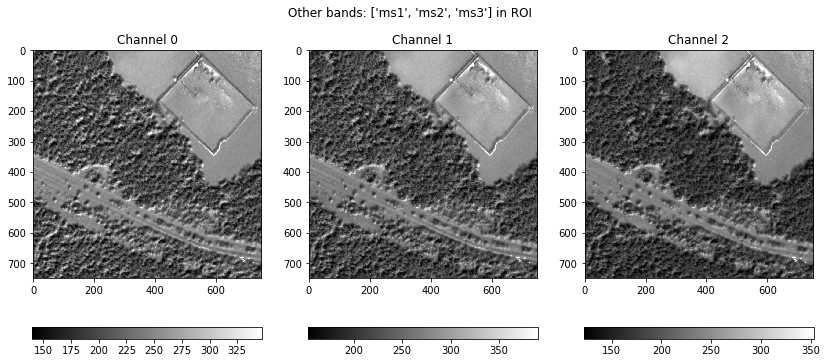

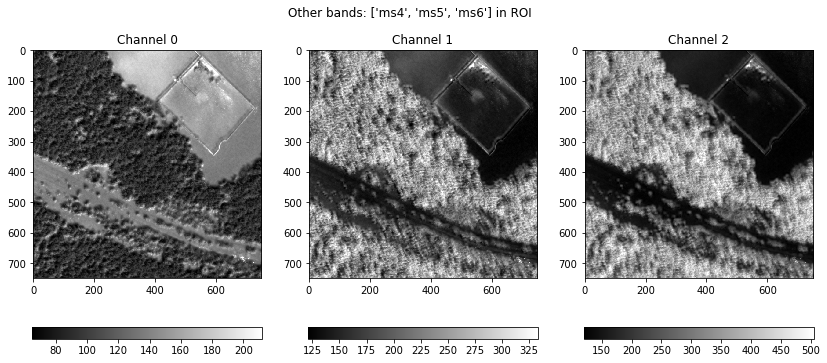

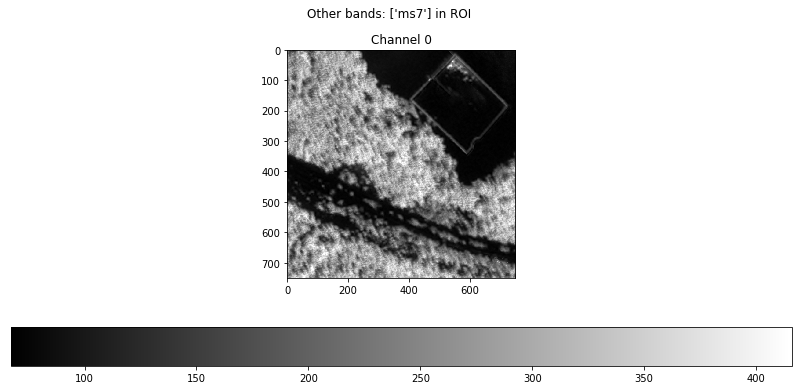

In [7]:
from ipywidgets import interact, IntSlider, FloatSlider   

#image_id = "6100_2_3"
image_id = "6080_4_3"


try:
    label_img = generate_label_image(image_id)
    is_test_image=False
except:
    is_test_image=True
        
img_input = get_image_data(image_id, 'input')

ch_desc = ['pan', 'ndvi', 'gemi', 'ndwi2', 'ndti', 'bi', 'bi2', '-bi', '-bi2', 'ms0', 'ms1', 'ms2', 'ms3', 'ms4', 'ms5', 'ms6', 'ms7']

fig_size = (14, 6)
plus_shapes = False
def interactive_visu(roi_x, roi_w, roi_y, roi_h, alpha):
    
    roi = [roi_x, roi_y, roi_x+roi_w, roi_y+roi_h]
    
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
#     img_pan_median = median_blur(img_input[:,:,0], 7)
#     display_img_1b(img_pan_median)
    display_img_1b(img_input[:,:,0])
    if not is_test_image:
        display_labels(label_img, alpha=alpha)
    ax.add_patch(Rectangle((roi_x, roi_y), roi_w, roi_h, alpha=1, facecolor='none', edgecolor='red'))
    plt.suptitle("Pansharpened image")
    
    plt.figure(figsize=fig_size)
    plt.subplot(121)
    display_img_1b(img_input[:,:,0], roi)
    plt.suptitle("Pansharpened image ROI")
    plt.subplot(122)
    display_img_1b(img_input[:,:,0], roi)
    if not is_test_image:
        display_labels(label_img, roi, alpha=alpha)
    plt.suptitle("Pansharpened image ROI + SHP")

    nc = img_input.shape[2] - 1
    n = int(np.ceil(nc / 3.0))
    count=1
    for i in range(n):
        plt.figure(figsize=fig_size)
        ax_array = display_img_3b(img_input[:,:,count:count+3], roi)
        plt.suptitle("Other bands: {} in ROI".format(ch_desc[count:count+3]))
        count += 3
        if plus_shapes and not is_test_image:
            display_labels(label_img, roi, ax_array, alpha=alpha)
            
        
    
_ = interact(interactive_visu,           
         roi_x=IntSlider(value=1, min=0, max=3500, continuous_update=False), 
         roi_w=IntSlider(value=500, min=150, max=750, continuous_update=False), 
         roi_y=IntSlider(value=1, min=0, max=3500, continuous_update=False), 
         roi_h=IntSlider(value=500, min=150, max=750, continuous_update=False),
         alpha=FloatSlider(value=0.5, min=0, max=1.0, step=0.1, continuous_update=False))

## Data iterator

In [85]:
from training_utils import tile_iterator

In [234]:
classes = [1,2,3,4,5]
image_ids_to_use = TRAIN_IMAGE_IDS
tile_generator = tile_iterator(image_ids_to_use, classes)

scale, xoffset_label, yoffset_label:  1 554 0
tile_size[0], gimg_input.shape[1], gimg_input.shape[1] - xoffset_label 256 3396 2842
(256L, 256L, 17L) (256L, 256L, 5L)


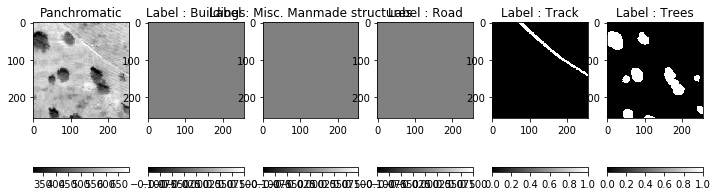

In [249]:
for x, y in tile_generator:
    print x.shape, y.shape
    plt.figure(figsize=(12,6))
    n_labels = y.shape[2]
    if n_labels < 8:
        n, m = 1, n_labels+1
    else:
        n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5) + 1,     
    plt.subplot(n,m,1)
    display_img_1b(x[:,:,0])
    plt.title("Panchromatic")    
    for j in range(n_labels):
        plt.subplot(n,m,j+2)
        display_img_1b(y[:,:,j])
        plt.title("Label : %s" % LABELS[classes[j]])
    
    break

## Remove sensor saturation

Check for saturation on panchromatic and all MS

In [18]:
generate_pansharpened(image_id, 'ms')

In [19]:
image_id = "6120_3_2"

img_pan = get_image_data(image_id, 'pan')
img_ms = get_image_data(image_id, 'ms_pan')

In [20]:
from image_utils import normalize, spot_cleaning

In [21]:
img_pan_cleaned = spot_cleaning(img_pan, 7, 0.1)

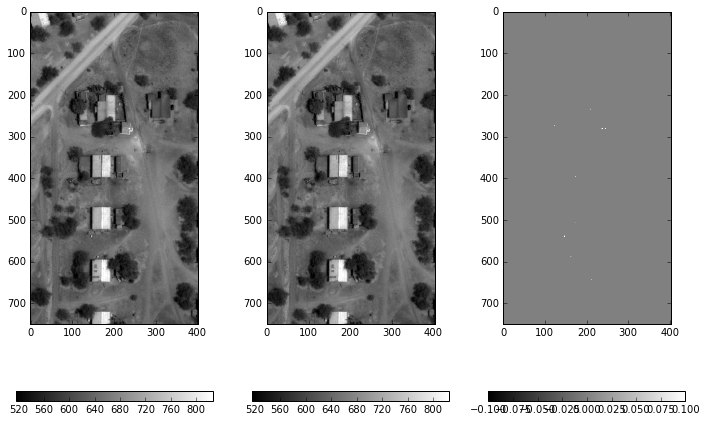

In [22]:
roi=[3000, 750, 3500, 1500]
plt.figure(figsize=(12,8))
plt.subplot(131)
display_img_1b(img_pan, roi=roi)
plt.subplot(132)
display_img_1b(img_pan_cleaned, roi=roi)
# display_img_1b(diff, roi=roi)
plt.subplot(133)
display_img_1b(np.abs(img_pan_cleaned.astype(np.float32) - img_pan.astype(np.float32)), roi=roi)

In [33]:
img_ms_cleaned = spot_cleaning(img_ms, 7, 0.1)

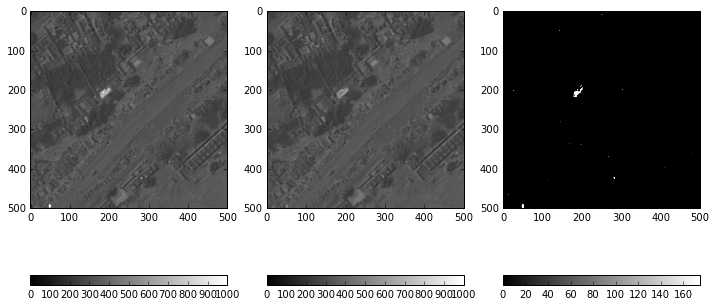

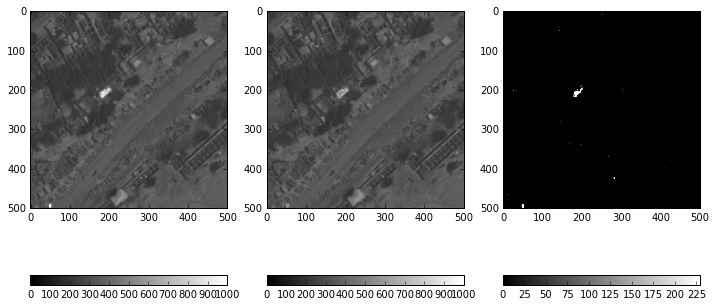

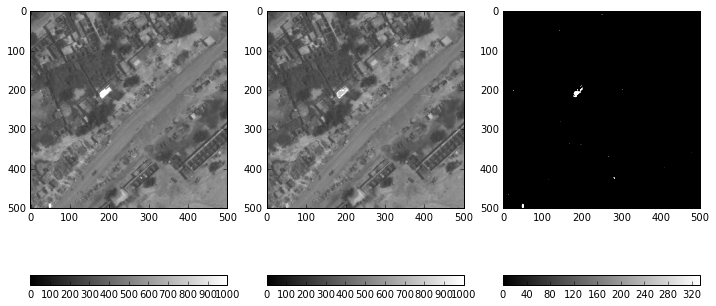

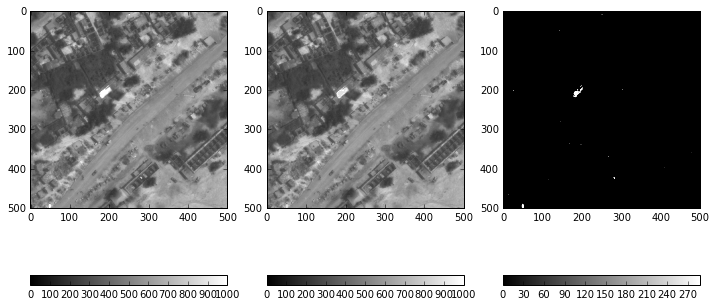

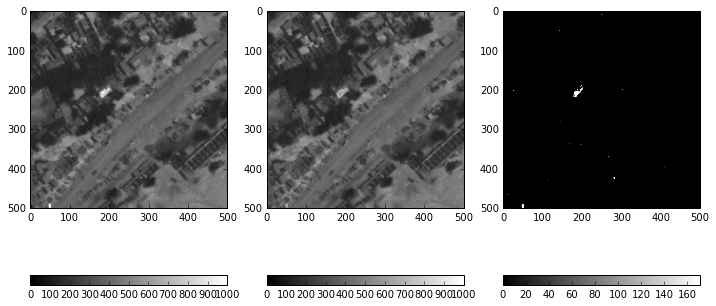

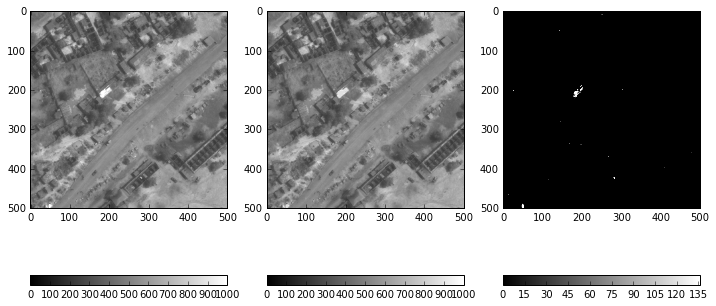

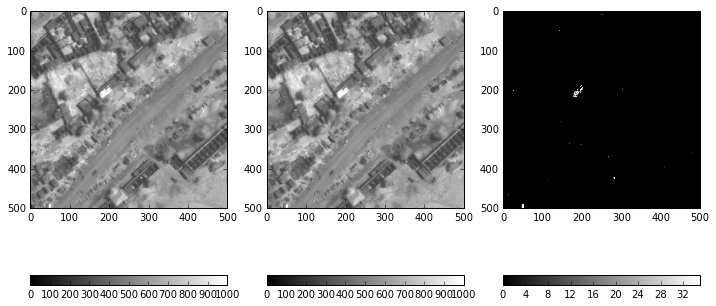

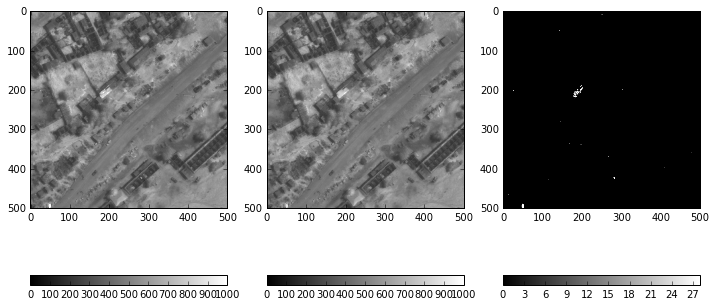

In [34]:
roi=[0, 0, 500, 500]
# roi=None
for i in range(img_ms.shape[2]):
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    display_img_1b(img_ms[:,:,i], clim=[0, 1000], roi=roi)
    plt.subplot(132)
    display_img_1b(img_ms_cleaned[:,:,i], clim=[0, 1000], roi=roi)
    plt.subplot(133)
    display_img_1b(np.abs(img_ms_cleaned[:,:,i].astype(np.float32) - img_ms[:,:,i].astype(np.float32)), roi=roi)